In [1]:
%matplotlib inline
import opengm
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

# images source: https://www.irisa.fr/vista/Themes/Demos/Debruitage/ImageDenoising.html
# input_img = './images/Brain_9pct_u881_z.png'
# image = Image.open(input_img).convert("L")
# img = np.asarray(image).astype(float)/255
# plt.imshow(img, cmap = cm.Greys_r)
# plt.show()

In [2]:
# Generate random binary image
# source: http://www.shogun-toolbox.org/static/notebook/current/Binary_Denoising.html
import scipy.ndimage
im_size = np.array([40, 60], np.int32)
im_rand = np.random.random_sample(im_size)
# print im_rand[0:10, 0:10]
im_bw = np.round(scipy.ndimage.gaussian_filter(im_rand, sigma=3))
# print im_bw[0:10, 0:10]
noise_level = 5
t = np.random.random_sample(im_bw.shape)
im_noise = im_bw*(1-t**noise_level) + (1-im_bw)*(t**noise_level)
im_noise = np.round(im_noise)  # image binarization

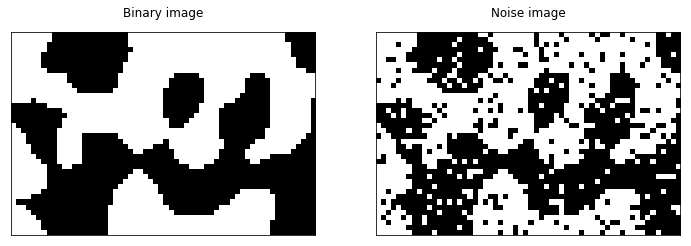

In [3]:
# black is 0, white is 1
fig, plots = plt.subplots(1, 2, figsize=(12, 4))
plots[0].matshow(im_bw, cmap=cm.Greys_r)
plots[0].set_title('Binary image')
plots[1].matshow(im_noise, cmap=cm.Greys_r)
plots[1].set_title('Noise image')
# print im_bw[0:10, 30:40]
for p in plots:
    p.set_xticks(())
    p.set_yticks(())
plt.show()

In [4]:
dimy, dimx = im_noise.shape
nvar = dimx * dimy
num_labels = 2
nstates = np.ones(nvar, dtype=opengm.index_type) * num_labels
gm = opengm.graphicalModel(nstates)

beta = 0.3
nu = 0.3

# add unary factors
for y in xrange(dimy):
    for x in xrange(dimx):
        f = np.ones(2, dtype=np.float32)
        if im_noise[y,x] == 0:
            f[0] = -nu
            f[1] = nu
        else:
            f[1] = -nu
            f[0] = nu
        fid = gm.addFunction(f)
        gm.addFactor(fid, (y * dimx + x,))

# x_i and x_j factor
f1=np.ones((2,2), dtype=np.float32)
f1[0,0] = -beta
f1[1,1] = -beta
f1[0,1] = beta
f1[1,0] = beta


fid1 = gm.addFunction(f1)

for y in xrange(dimy):
    for x in xrange(dimx):
        if x + 1 < dimx:
            gm.addFactor(fid1, np.array([y * dimx + x, y * dimx + x + 1]))
        if y + 1 < dimy:
            gm.addFactor(fid1, np.array([y * dimx + x, (y+1) * dimx + x]))

In [5]:
# opengm.visualizeGm(gm,plotFunctions=False, layout='neato', plotUnaries=True,
#                     plotNonShared=True,relNodeSize=1.0)

In [10]:
imgplot=[]

class PyCallback(object):
    def appendLabelVector(self,labelVector):
        #save the labels at each iteration, to examine later.
        labelVector=labelVector.reshape(self.shape)
        imgplot.append([labelVector])
    def __init__(self,shape,numLabels):
        self.shape=shape
        self.numLabels=numLabels
        #matplotlib.interactive(True)
        plt.interactive(True)
    def checkEnergy(self,inference):
        gm=inference.gm()
        #the arg method returns the (class) labeling at each pixel.
        labelVector=inference.arg()
        #evaluate the energy of the graph given the current labeling.
        print "energy  ",gm.evaluate(labelVector)
        self.appendLabelVector(labelVector)
    def begin(self,inference):
        print "beginning of inference"
        self.checkEnergy(inference)
    def end(self,inference):
        print "end of inference"
    def visit(self,inference):
        self.checkEnergy(inference)

inf=opengm.inference.BeliefPropagation(gm,parameter=opengm.InfParam(damping=0.00))
callback=PyCallback(im_noise.shape,num_labels)
visitor=inf.pythonVisitor(callback,visitNth=1)

inf.infer(visitor)
# inf.infer()
# result = inf.arg()

In [7]:
# fig = plt.figure(figsize=(16, 12))
# for (counter, im) in enumerate(imgplot[0:6]):
#     a=fig.add_subplot(3,2,counter+1)
#     plt.imshow(im[0],cmap=cm.gray_r, interpolation="nearest")

# plt.draw()

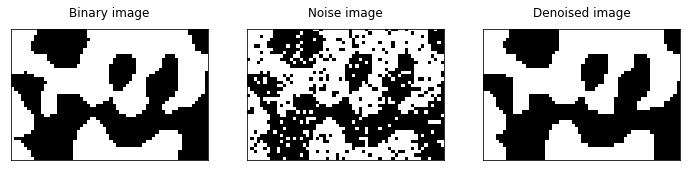

In [14]:
fig, plots = plt.subplots(1, 3, figsize=(12, 4))
plots[0].matshow(im_bw, cmap=cm.Greys_r)
plots[0].set_title('Binary image')
plots[1].matshow(im_noise, cmap=cm.Greys_r)
plots[1].set_title('Noise image')
plots[2].matshow(imgplot[-1][0], cmap=cm.Greys_r)
# plots[2].matshow(result.reshape(im_bw.shape), cmap=cm.Greys_r)
plots[2].set_title('Denoised image')
for p in plots:
    p.set_xticks(())
    p.set_yticks(())
plt.show()